<a href="https://colab.research.google.com/github/eughappy/HomeWork/blob/neural_network/hw11.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import keras as K
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [2]:
num_classes = 10 # загальна кількість класів, у нашому випадку це цифри від 0 до 9
num_features = 784 # кількість атрибутів вхідного вектора 28 * 28 = 784

learning_rate = 0.001 # швидкість навчання нейронної мережі
training_steps = 3000 # максимальне число епох
batch_size = 256 # перераховувати ваги мережі ми будемо не на всій вибірці, а на її випадковій підмножині з batch_size елементів
display_step = 100 # кожні 100 ітерацій ми будемо показувати поточне значення функції втрат і точності

n_hidden_1 = 128 # кількість нейронів 1-го шару
n_hidden_2 = 256 # кількість нейронів 2-го шару

In [3]:
# from tensorflow.keras.datasets import mnist
from keras.datasets import mnist

# Завантажуємо датасет
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Перетворюємо цілочисельні пікселі на тип float32
x_train, x_test = np.array(x_train, np.float32), np.array(x_test, np.float32)

# Перетворюємо матриці розміром 28x28 пікселів у вектор з 784 елементів
x_train, x_test = x_train.reshape([-1, num_features]), x_test.reshape([-1, num_features])

# Нормалізуємо значення пікселів
x_train, x_test = x_train / 255., x_test / 255.

# Перемішаємо тренувальні дані
train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_data = train_data.repeat().shuffle(5000).batch(batch_size).prefetch(1)

11490434/11490434 [==============================] - 0s 0us/step


In [4]:
# Створимо нейронну мережу

class DenseLayer(tf.Module):
    def __init__(self, in_features, out_features, name=None):
        super().__init__(name=name)
        self.w = tf.Variable(
            tf.random.normal([in_features, out_features]), name="w"
        )
        self.b = tf.Variable(tf.zeros([out_features]), name="b")

    def __call__(self, x, activation=0):
        y = tf.matmul(x, self.w) + self.b
        if activation != 0:
            return tf.nn.softmax(y)
        else:
            return tf.nn.sigmoid(y)

class NN(tf.Module):
    def __init__(self, name=None):
        super().__init__(name=name)
        self.layer_1 = DenseLayer(num_features, n_hidden_1)
        self.layer_2 = DenseLayer(n_hidden_1, n_hidden_2)
        self.out = DenseLayer(n_hidden_2, num_classes)

    def __call__(self, x):
        x = self.layer_1(x)
        x = self.layer_2(x)
        x = self.out(x, activation=1)
        return x

In [5]:
# В якості функції помилки в даному випадку зручно взяти крос-ентропію
def cross_entropy(y_pred, y_true):
    # Закодувати label в one hot vector
    y_true = tf.one_hot(y_true, depth=num_classes)

    # Значення передбачення, щоб уникнути помилки log(0).
    y_pred = tf.clip_by_value(y_pred, 1e-9, 1.)

    # Обчислення крос-ентропії
    return tf.reduce_mean(-tf.reduce_sum(y_true * tf.math.log(y_pred)))

# Як метрику якості використовуємо точність
def accuracy(y_pred, y_true):
    correct_prediction = tf.equal(tf.argmax(y_pred, 1), tf.cast(y_true, tf.int64))
    return tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [6]:
# Створимо екземпляр нейронної мережі
neural_net = NN(name="mnist")

# Функція навчання нейромережі
def train(neural_net, input_x, output_y):
    # Для налаштування вагів мережі будемо використовувати стохастичний градієнтний спуск
    optimizer = tf.optimizers.SGD(learning_rate)

    # Активація автоматичного диференціювання
    with tf.GradientTape() as g:
        pred = neural_net(input_x)
        loss = cross_entropy(pred, output_y)

    # Отримаємо список оптимізованих параметрів
    trainable_variables = neural_net.trainable_variables

    # Обчислимо за ними значення градієнта
    gradients = g.gradient(loss, trainable_variables)

    # Модифікуємо параметри
    optimizer.apply_gradients(zip(gradients, trainable_variables))

In [7]:
# Тренування мережі

loss_history = []  # кожні display_step кроків зберігай в цьому списку поточну помилку нейромережі
accuracy_history = [] # кожні display_step кроків зберігай в цьому списку поточну точність нейромережі

# У цьому циклі ми будемо проводити навчання нейронної мережі
# із тренувального датасета train_data вилучи випадкову підмножину, на якій
# відбудеться тренування. Використовуй метод take, доступний для тренувального датасета.
for step, (batch_x, batch_y) in enumerate(train_data.take(training_steps), 1):
    # Оновлюємо ваги нейронної мережі
    train(neural_net, batch_x, batch_y)

    if step % display_step == 0:
        pred = neural_net(batch_x)
        loss = cross_entropy(pred, batch_y)
        acc = accuracy(pred, batch_y)
        loss_history.append(loss)
        accuracy_history.append(acc)
        print(f"Step: {step}, Loss: {loss.numpy()}, Accuracy: {acc.numpy()}")

Step: 100, Loss: 318.9712829589844, Accuracy: 0.63671875
Step: 200, Loss: 223.4646453857422, Accuracy: 0.75390625
Step: 300, Loss: 160.40628051757812, Accuracy: 0.8125
Step: 400, Loss: 161.87075805664062, Accuracy: 0.796875
Step: 500, Loss: 128.4371337890625, Accuracy: 0.86328125
Step: 600, Loss: 175.136962890625, Accuracy: 0.78515625
Step: 700, Loss: 86.2262954711914, Accuracy: 0.90625
Step: 800, Loss: 94.72782135009766, Accuracy: 0.90234375
Step: 900, Loss: 134.35101318359375, Accuracy: 0.84375
Step: 1000, Loss: 108.20635986328125, Accuracy: 0.86328125
Step: 1100, Loss: 85.78584289550781, Accuracy: 0.90234375
Step: 1200, Loss: 114.0323257446289, Accuracy: 0.890625
Step: 1300, Loss: 114.38877868652344, Accuracy: 0.86328125
Step: 1400, Loss: 78.57344055175781, Accuracy: 0.890625
Step: 1500, Loss: 101.0775146484375, Accuracy: 0.8984375
Step: 1600, Loss: 79.51658630371094, Accuracy: 0.91015625
Step: 1700, Loss: 104.86322021484375, Accuracy: 0.875
Step: 1800, Loss: 81.75143432617188, Accu

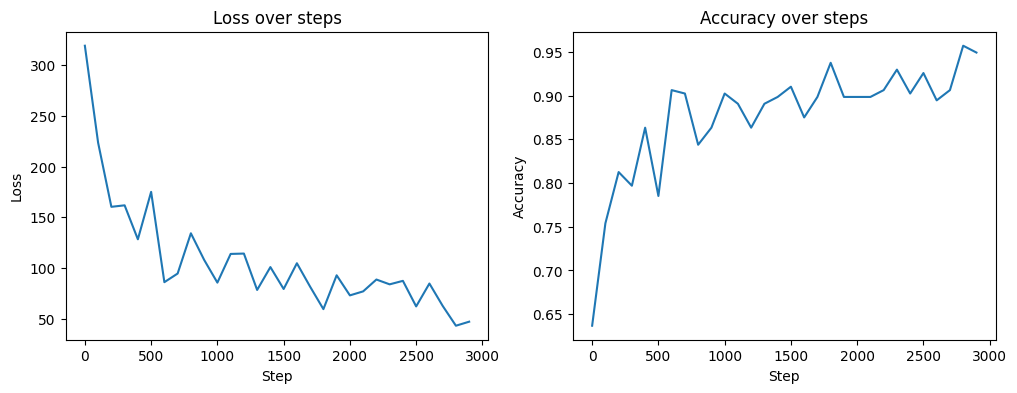

In [8]:
# Виведіть графіки залежності зміни точності і втрат від кроку
# Якщо все зроблено правильно, то точність повинна зростати, а втрати зменшуватись

import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(range(0, training_steps, display_step), loss_history)
plt.title('Loss over steps')
plt.xlabel('Step')
plt.ylabel('Loss')

plt.subplot(1, 2, 2)
plt.plot(range(0, training_steps, display_step), accuracy_history)
plt.title('Accuracy over steps')
plt.xlabel('Step')
plt.ylabel('Accuracy')
plt.show()


In [9]:
# Обчисліть точність навченої нейромережі
pred = neural_net(x_test)
test_acc = accuracy(pred, y_test)
print(f"Test Accuracy: {test_acc.numpy()}")

Test Accuracy: 0.9032999873161316


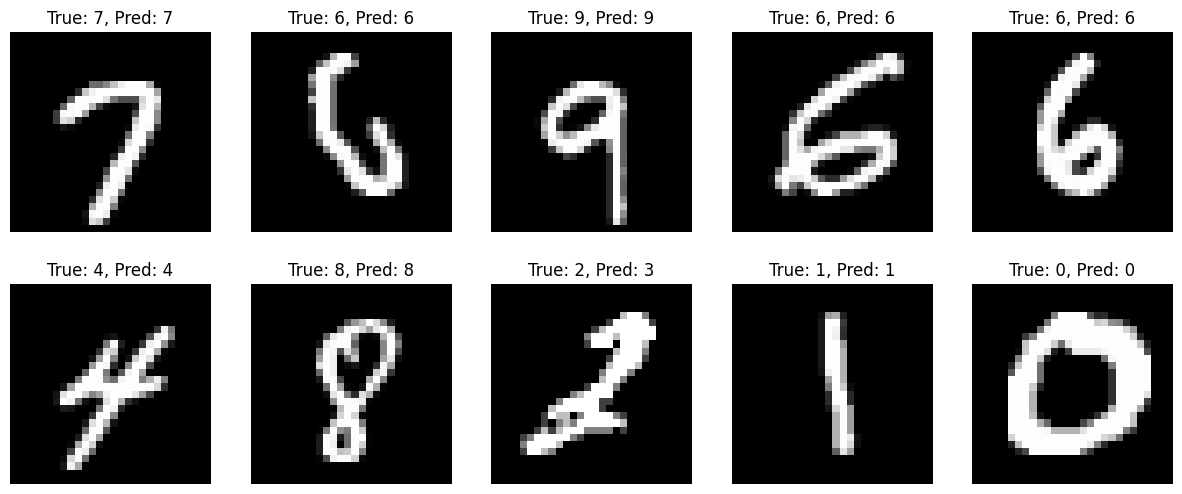

In [10]:
# Протестуйте навчену нейромережу на 10 зображеннях. З тестової вибірки візьміть 5
# випадкових зображень і передайте їх у нейронну мережу.
# Виведіть зображення та випишіть  поруч відповідь нейромережі.
# Зробіть висновок про те, чи помиляється твоя нейронна мережа, і якщо так, то як часто?

num_images_to_test = 10
indices = random.sample(range(len(x_test)), num_images_to_test)
sample_images = x_test[indices]
sample_labels = y_test[indices]
predictions = neural_net(sample_images)
predicted_labels = tf.argmax(predictions, axis=1)

plt.figure(figsize=(15, 6))
for i in range(num_images_to_test):
    plt.subplot(2, 5, i+1)
    plt.imshow(sample_images[i].reshape(28, 28), cmap='gray')
    plt.title(f"True: {sample_labels[i]}, Pred: {predicted_labels[i].numpy()}")
    plt.axis('off')
plt.show()



***Модель зробила одну помилку з десяти, що говорить про те, що навчана гарно. Можливо, якщо збільшити кількість епох або швидкість навчання або ще якісь параметри, можна отримати кращі результати, а саме 10/10. ***